In [1]:
%matplotlib inline

import polars as pl
import pandas as pd
import numpy as np
import kagglehub

# Chapter 10: Selecting and Creating columns 
import polars.selectors as cs

# Chapter 16: Visualizing Data 
import altair as alt
import hvplot.polars
from bokeh.models import NumeralTickFormatter, Title

hvplot.extension("bokeh")

import warnings
warnings.filterwarnings("ignore")

import panel as pn
pn.extension()

# Objective:
Analyze transactional e-commerce data to understand customer behavior, segment customers, and build predictive models to support marketing and revenue optimization.

Stakeholders:
- Marketing
- Sales
- Operations

Decisions supported:
- Who should we target?
- Which customers are at risk?
- Which products to bundle?

## Preprocessing 

- TotalPrice = Quantity * UnitPrice
- InvoiceMonth
- InvoiceWeek
- InvoiceDayOfWeek
- InvoiceHour
- IsReturn


In [68]:
path = kagglehub.dataset_download("carrie1/ecommerce-data")

In [2]:
filename = r"C:\Users\jarmo\Documents\Business\Projects\UK ECommerce Data\data\data.csv"
df = pl.read_csv(filename, 
                schema_overrides = {"InvoiceNo": pl.Utf8, 'CustomerID': pl.String},
                encoding = "cp1252")

df = df.with_row_count("index")
df = df.with_columns(
    (pl.col('Quantity') * pl.col("UnitPrice")) 
    .alias("Revenue")
)
    

df.head()

index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
u32,str,str,str,i64,str,f64,str,str,f64
0,"""536365""","""85123A""","""WHITE HANGING HEART T-LIGHT HO…",6,"""12/1/2010 8:26""",2.55,"""17850""","""United Kingdom""",15.3
1,"""536365""","""71053""","""WHITE METAL LANTERN""",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34
2,"""536365""","""84406B""","""CREAM CUPID HEARTS COAT HANGER""",8,"""12/1/2010 8:26""",2.75,"""17850""","""United Kingdom""",22.0
3,"""536365""","""84029G""","""KNITTED UNION FLAG HOT WATER B…",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34
4,"""536365""","""84029E""","""RED WOOLLY HOTTIE WHITE HEART.""",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34


## 1. Exploratory Data Analysis (EDA)
Goal: **Understand the structure, quality, and patterns in the data.**


In [5]:
print("Data has {} rows and {} columns".format(df.shape[0], df.shape[1]))

Data has 541909 rows and 10 columns


In [6]:
print("\033[1mData types: \033[0m")
for i, j in zip(df.columns, df.dtypes): 
    print("{:<12} : {}".format(i, j))

Data types: 
index        : UInt32
InvoiceNo    : String
StockCode    : String
Description  : String
Quantity     : Int64
InvoiceDate  : String
UnitPrice    : Float64
CustomerID   : String
Country      : String
Revenue      : Float64


In [7]:
null_counts = df.null_count().to_dict(as_series=False) 

print("\033[1mNumber of invalid values: \033[0m")
for i, j in zip(null_counts.keys(), null_counts.values()):
    print("{:>12}: {}".format(i, j[0]))


print("\nPercentage of invalid CustomerID's = {:.2f}%".format(null_counts['CustomerID'][0]/df.shape[0] * 100))

Number of invalid values: 
       index: 0
   InvoiceNo: 0
   StockCode: 0
 Description: 1454
    Quantity: 0
 InvoiceDate: 0
   UnitPrice: 0
  CustomerID: 135080
     Country: 0
     Revenue: 0

Percentage of invalid CustomerID's = 24.93%


#### Investigate CustomerID

In [8]:
null_customer = df.filter(pl.col("CustomerID").is_null())
null_customer.head()



index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
u32,str,str,str,i64,str,f64,str,str,f64
622,"""536414""","""22139""",null,56,"""12/1/2010 11:52""",0.0,null,"""United Kingdom""",0.0
1443,"""536544""","""21773""","""DECORATIVE ROSE BATHROOM BOTTL…",1,"""12/1/2010 14:32""",2.51,null,"""United Kingdom""",2.51
1444,"""536544""","""21774""","""DECORATIVE CATS BATHROOM BOTTL…",2,"""12/1/2010 14:32""",2.51,null,"""United Kingdom""",5.02
1445,"""536544""","""21786""","""POLKADOT RAIN HAT """,4,"""12/1/2010 14:32""",0.85,null,"""United Kingdom""",3.4
1446,"""536544""","""21787""","""RAIN PONCHO RETROSPOT""",2,"""12/1/2010 14:32""",1.66,null,"""United Kingdom""",3.32


In [9]:
country_null_revenue = (null_customer.select("Country", "Revenue")
.group_by("Country")
.sum()
.sort(by = 'Revenue', descending = True)
                       )

plot1 = alt.Chart(country_null_revenue).mark_bar().encode(
    x = alt.X('Country', title = "Country"),
    y = alt.Y('Revenue', title = "Revenue in ($)")
).properties(
    width = 400, 
    height = 250, 
    title = "Total Revenue"
)

note = alt.Chart({
    "values": [{"text": "Revenue of undocumented transactions (USD)"}]
}).mark_text(
    color = 'black',
    fontSize = 12).encode(
    text = "text:N"
    )

alt.hconcat(plot1, note)




alt.HConcatChart(...)

#### Look into the countries with no CustomerID


In [10]:
frequency_table_country_null = country_null_revenue.with_columns(
    ( (pl.col("Revenue")/pl.col("Revenue").sum()) * 100) 
    .alias("Relative Frequency")
).sort(by = 'Relative Frequency', descending=True)

print(frequency_table_country_null)
print("{} accounts for {:.2f}% of the total Revenue of transactions that have no DocumentID. \
\nThe total revenue of these transactions is ${:.2f}.".format(
    frequency_table_country_null['Country'][0],
    frequency_table_country_null['Relative Frequency'][0], 
    frequency_table_country_null['Revenue'][0]
))

shape: (9, 3)
┌────────────────┬──────────┬────────────────────┐
│ Country        ┆ Revenue  ┆ Relative Frequency │
│ ---            ┆ ---      ┆ ---                │
│ str            ┆ f64      ┆ f64                │
╞════════════════╪══════════╪════════════════════╡
│ United Kingdom ┆ 1.4199e6 ┆ 98.083201          │
│ EIRE           ┆ 12991.6  ┆ 0.897407           │
│ Hong Kong      ┆ 10117.04 ┆ 0.698844           │
│ Unspecified    ┆ 2082.72  ┆ 0.143866           │
│ Israel         ┆ 913.57   ┆ 0.063106           │
│ France         ┆ 691.06   ┆ 0.047736           │
│ Switzerland    ┆ 645.95   ┆ 0.04462            │
│ Portugal       ┆ 307.21   ┆ 0.021221           │
│ Bahrain        ┆ 0.0      ┆ 0.0                │
└────────────────┴──────────┴────────────────────┘
United Kingdom accounts for 98.08% of the total Revenue of transactions that have no DocumentID. 
The total revenue of these transactions is $1419932.97.


In [11]:
df_uk = df.filter(
    (pl.col("Country") == "United Kingdom"))

print("{:.2f}% Of all transactions come from the United Kingdom with no CustomerID.".format(
    df_uk.filter(pl.col("CustomerID").is_null()).shape[0] / df.shape[0] * 100
))

print("{:.2f}% Of all transactions from the UK have no CustomerID".format(
    df_uk.filter(pl.col("CustomerID").is_null()).shape[0]/df_uk.shape[0] * 100
))

24.65% Of all transactions come from the United Kingdom with no CustomerID.
26.96% Of all transactions from the UK have no CustomerID


In [41]:
print("Number of transactions with zero or negative unit price: {:>6}".format(df.filter(pl.col("UnitPrice") <= 0.0).shape[0]))
print("Number of transactions with no CustomerID: {:>22}".format(df.filter(pl.col("CustomerID").is_null()).shape[0]))
print("Number of transactions with zero or negative quantity: {:>9}".format(df.filter(pl.col("Quantity") <= 0).shape[0]))
print("Number of transactions with no description: {:>19}".format(df.filter(pl.col("Description").is_null()).shape[0]))



Number of transactions with zero or negative unit price:   2517
Number of transactions with no CustomerID:                 135080
Number of transactions with zero or negative quantity:     10624
Number of transactions with no description:                1454


#### Question: What are the reasons for negative and or zero values in the dataset?

How can this be fixed in the future? 

#### Filter out invalid data

In order to continue analysis, we remove all the invalids.

In [47]:
df_new = df.drop_nulls()
print(df_new.null_count())

shape: (1, 10)
┌───────┬───────────┬───────────┬─────────────┬───┬───────────┬────────────┬─────────┬─────────┐
│ index ┆ InvoiceNo ┆ StockCode ┆ Description ┆ … ┆ UnitPrice ┆ CustomerID ┆ Country ┆ Revenue │
│ ---   ┆ ---       ┆ ---       ┆ ---         ┆   ┆ ---       ┆ ---        ┆ ---     ┆ ---     │
│ u32   ┆ u32       ┆ u32       ┆ u32         ┆   ┆ u32       ┆ u32        ┆ u32     ┆ u32     │
╞═══════╪═══════════╪═══════════╪═════════════╪═══╪═══════════╪════════════╪═════════╪═════════╡
│ 0     ┆ 0         ┆ 0         ┆ 0           ┆ … ┆ 0         ┆ 0          ┆ 0       ┆ 0       │
└───────┴───────────┴───────────┴─────────────┴───┴───────────┴────────────┴─────────┴─────────┘


In [54]:
## Some statistics about invalids 
print("The data is reduced by {:.2f}%.".format(np.abs((df_new.shape[0] - df.shape[0])/df.shape[0] * 100)))
print("Original data has dimensions: {}, filtered data has dimensions: {}".format(df.shape, df_new.shape))

The data is reduced by 24.93%.
Original data has dimensions: (541909, 10), filtered data has dimensions: (406829, 10)


In [66]:
df_new.write_csv("ecommerce_filtered.csv")

In [61]:
st.title("Ecommerce Insights")
st.write("This app gives insight in the global e-commerce transactions.")



2026-02-16 17:35:54.321 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-16 17:35:54.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-16 17:35:54.332 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-16 17:35:54.336 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-16 17:35:54.339 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2026-02-16 17:35:54.341 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [67]:
!streamlit run Dashboard_Ecommerce.py

^C


# Dashboard

In [29]:
# ---------------------------
# DataProcessor.py
# ---------------------------
import polars as pl
from datetime import datetime

class DataProcessor:
    def __init__(self, filename: str):
        self.filename = filename
        self.df_lazy = self._read_csv()

        self._returns_only = None
        self._sales_only = None

    # -------------------------
    # Load CSV + parse dates robustly
    # -------------------------
    def _read_csv(self):
        # Lazy scan with correct schema
        df_scan = pl.scan_csv(
            self.filename,
            schema_overrides={
                "InvoiceNo": pl.Utf8,   # <- treat InvoiceNo as string
                "CustomerID": pl.Utf8    # <- treat CustomerID as string
            },
            encoding="utf8-lossy",
            ignore_errors=True,         # ignore rows with parsing issues
        ).drop_nulls()
    
        # Parse InvoiceDate robustly
        invoice_dates = df_scan.select("InvoiceDate").collect()["InvoiceDate"].to_list()
        parsed_dates = []
        for val in invoice_dates:
            dt = None
            for fmt in ("%m/%d/%Y %H:%M", "%Y-%m-%d %H:%M:%S"):
                try:
                    dt = datetime.strptime(val, fmt)
                    break
                except:
                    continue
            parsed_dates.append(dt)
    
        dates_df = pl.DataFrame({
            "InvoiceDate": invoice_dates,
            "DateTime": parsed_dates,
            "Date": [d.date() if d else None for d in parsed_dates]
        })
    
        df_lazy = df_scan.join(dates_df.lazy(), on="InvoiceDate", how="left")

    
        # Compute Revenue
        df_lazy = df_lazy.with_columns((pl.col("Quantity") * pl.col("UnitPrice")).alias("Revenue"))
    
        return df_lazy


    # -------------------------
    # Unique countries
    # -------------------------
    @property
    def unique_countries(self):
        return (
            self.df_lazy.select(pl.col("Country").unique())
            .sort("Country")
            .collect()
            .to_series()
            .to_list()
        )

    # -------------------------
    # Unique products for a country
    # -------------------------
    def unique_products(self, country: str):
        return (
            self.sales_only
            .filter(pl.col("Country") == country)
            .select("Description")
            .unique()
            .sort("Description")
            .collect()
            .to_series()
            .to_list()
        )

    # -------------------------
    # Returns dataset
    # -------------------------
    @property
    def returns_only(self):
        if self._returns_only is None:
            self._returns_only = (
                self.df_lazy
                .filter(pl.col("InvoiceNo").str.starts_with("C"))
                .with_columns(
                    pl.col("InvoiceNo").str.replace("^C", "").alias("OriginalInvoiceNo")
                )
                .select(["OriginalInvoiceNo", "StockCode", "CustomerID"])
            )
        return self._returns_only

    # -------------------------
    # Sales excluding returns
    # -------------------------
    @property
    def sales_only(self):
        if self._sales_only is None:
            self._sales_only = (
                self.df_lazy
                .filter(~pl.col("InvoiceNo").str.starts_with("C"))
                .join(
                    self.returns_only,
                    left_on=["InvoiceNo", "StockCode", "CustomerID"],
                    right_on=["OriginalInvoiceNo", "StockCode", "CustomerID"],
                    how="anti"
                )
            )
        return self._sales_only

    # -------------------------
    # Revenue per article per country
    # -------------------------
    def revenue_per_article_per_country(self, country: str):
        return (
            self.sales_only
            .filter(pl.col("Country") == country)
            .group_by("Description")
            .agg(pl.col("Revenue").sum())
            .sort("Revenue", descending=True)
            .head(15)
            .collect()
        )

    # -------------------------
    # Total revenue vs country
    # -------------------------
    def total_revenue_vs_country(self, country: str):
        total_revenue = self.df_lazy.select(pl.col("Revenue").sum()).collect().to_series()[0]
        country_revenue = self.df_lazy.filter(pl.col("Country") == country).select(pl.col("Revenue").sum()).collect().to_series()[0]
        country_perc = f"{(country_revenue / total_revenue * 100):.2f}"

        df = pl.DataFrame({
            "Country": ["Total Global Revenue", country],
            "Revenue": [total_revenue, country_revenue],
            "% of total": ["", country_perc]
        })
        return df.to_pandas()

    # -------------------------
    # Quantity per article for country
    # -------------------------
    def get_country_quantity(self, country: str, product: str):
        return (
            self.sales_only
            .filter((pl.col("Country") == country) & (pl.col("Description") == product))
            .group_by("Date")
            .agg(pl.col("Quantity").sum().alias("Quantity"))
            .sort("Date")
            .collect()
        )

    # -------------------------
    # Quantity per article for global (excluding selected country)
    # -------------------------
    def get_global_quantity(self, country: str, product: str):
        country_set = str(country)
        country_df = self.get_country_quantity(country, product)
        country_dates = country_df.select("Date").to_series().to_list()

        return (
            self.sales_only
            .filter((pl.col("Country") != country_set) & (pl.col("Description") == product) & pl.col("Date").is_in(country_dates))
            .group_by("Date")
            .agg(pl.col("Quantity").sum().alias("Quantity"))
            .sort("Date")
            .collect()
        )


In [30]:
filename = r"C:\Users\jarmo\Documents\Business\Projects\UK ECommerce Data\data\data.csv"
a = DataProcessor(filename)
b = a.unique_products("United Kingdom")
b



[' 4 PURPLE FLOCK DINNER CANDLES',
 " 50'S CHRISTMAS GIFT BAG LARGE",
 ' DOLLY GIRL BEAKER',
 ' I LOVE LONDON MINI BACKPACK',
 ' NINE DRAWER OFFICE TIDY',
 ' OVAL WALL MIRROR DIAMANTE ',
 ' RED SPOT GIFT BAG LARGE',
 ' SET 2 TEA TOWELS I LOVE LONDON ',
 ' SPACEBOY BABY GIFT SET',
 ' TOADSTOOL BEDSIDE LIGHT ',
 ' TRELLIS COAT RACK',
 '10 COLOUR SPACEBOY PEN',
 '12 COLOURED PARTY BALLOONS',
 '12 DAISY PEGS IN WOOD BOX',
 '12 EGG HOUSE PAINTED WOOD',
 '12 HANGING EGGS HAND PAINTED',
 '12 IVORY ROSE PEG PLACE SETTINGS',
 '12 MESSAGE CARDS WITH ENVELOPES',
 '12 PENCIL SMALL TUBE WOODLAND',
 '12 PENCILS SMALL TUBE RED RETROSPOT',
 '12 PENCILS SMALL TUBE SKULL',
 '12 PENCILS TALL TUBE POSY',
 '12 PENCILS TALL TUBE RED RETROSPOT',
 '12 PENCILS TALL TUBE SKULLS',
 '12 PENCILS TALL TUBE WOODLAND',
 '12 PINK HEN+CHICKS IN BASKET',
 '12 PINK ROSE PEG PLACE SETTINGS',
 '12 RED ROSE PEG PLACE SETTINGS',
 '15 PINK FLUFFY CHICKS IN BOX',
 '15CM CHRISTMAS GLASS BALL 20 LIGHTS',
 '16 PC CUTLERY SET PANT

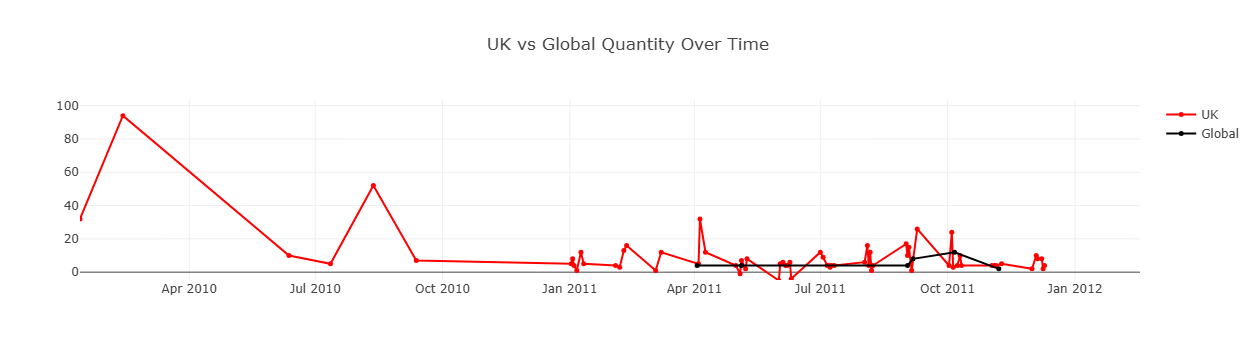

In [42]:
import streamlit as st
import polars as pl
import plotly.graph_objects as go
from datetime import timedelta

# --- 1. Filter and aggregate data in Polars ---

# Example: UK
UK = (
    a.df_lazy
    .filter(pl.col("Country") == "United Kingdom")
    .filter((pl.col("Description") == "WHITE METAL LANTERN") & pl.col("Date").is_not_null())
    .group_by("Date")
    .agg(pl.col("Quantity").sum().alias("Quantity"))
    .sort("Date")
    .collect()

)

# Example: Global (excluding UK)
global_ = (
    a.df_lazy
    .filter(pl.col("Country") != "United Kingdom")
    .filter((pl.col("Description") == "WHITE METAL LANTERN") & pl.col("Date").is_not_null())
    .group_by("Date")
    .agg(pl.col("Quantity").sum().alias("Quantity"))
    .sort("Date")
    .collect()
)

# --- 2. Compute axis limits in Polars ---
y_max = max(UK["Quantity"].max(), global_["Quantity"].max())

first_date = min(UK["Date"].min(), global_["Date"].min())
last_date = max(UK["Date"].max(), global_["Date"].max())

date_range_days = (last_date - first_date).days
extended_date = last_date + timedelta(days=int(date_range_days * 0.1))  # 10% padding

# --- 3. Convert Polars columns to Python lists for plotting ---
uk_dates = UK["Date"].to_list()
uk_qty = UK["Quantity"].to_list()

global_dates = global_["Date"].to_list()
global_qty = global_["Quantity"].to_list()

# --- 4. Create Plotly figure ---
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=uk_dates, y=uk_qty, mode="lines+markers",
    name="UK", line=dict(color="red", width=2), marker=dict(size=5)
))
fig.add_trace(go.Scatter(
    x=global_dates, y=global_qty, mode="lines+markers",
    name="Global", line=dict(color="black", width=2), marker=dict(size=5)
))

# Axis padding
fig.update_layout(
    title="UK vs Global Quantity Over Time",
    xaxis=dict(range=[first_date, extended_date]),
    yaxis=dict(range=[-y_max*0.05, y_max + y_max*0.1])
)

# --- 5. Display in Streamlit ---
fig


In [158]:
daily_heart

Date,Quantity
date,i64
null,996
2010-01-12,40
2010-02-12,85
2010-05-12,33
2010-06-12,12
…,…
2011-11-08,132
2011-11-09,2
2011-11-11,3


In [94]:
c = (a.df_lazy.with_columns(
    pl.col("InvoiceDate").dt.date().alias("Date"))
)
a.df_lazy.collect()

index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date
u32,str,str,str,i64,str,f64,str,str,f64,datetime[μs]
0,"""536365""","""85123A""","""WHITE HANGING HEART T-LIGHT HO…",6,"""12/1/2010 8:26""",2.55,"""17850""","""United Kingdom""",15.3,2010-01-12 08:26:00
1,"""536365""","""71053""","""WHITE METAL LANTERN""",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34,2010-01-12 08:26:00
2,"""536365""","""84406B""","""CREAM CUPID HEARTS COAT HANGER""",8,"""12/1/2010 8:26""",2.75,"""17850""","""United Kingdom""",22.0,2010-01-12 08:26:00
3,"""536365""","""84029G""","""KNITTED UNION FLAG HOT WATER B…",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34,2010-01-12 08:26:00
4,"""536365""","""84029E""","""RED WOOLLY HOTTIE WHITE HEART.""",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34,2010-01-12 08:26:00
…,…,…,…,…,…,…,…,…,…,…
406824,"""581587""","""22613""","""PACK OF 20 SPACEBOY NAPKINS""",12,"""12/9/2011 12:50""",0.85,"""12680""","""France""",10.2,2011-09-12 12:50:00
406825,"""581587""","""22899""","""CHILDREN'S APRON DOLLY GIRL """,6,"""12/9/2011 12:50""",2.1,"""12680""","""France""",12.6,2011-09-12 12:50:00
406826,"""581587""","""23254""","""CHILDRENS CUTLERY DOLLY GIRL """,4,"""12/9/2011 12:50""",4.15,"""12680""","""France""",16.6,2011-09-12 12:50:00


In [67]:
total_revenue = (a.df_lazy.select('Revenue').sum()).collect().to_series().to_list()[0]
country_revenue = (
    a.df_lazy
    .filter(pl.col("Country") == "United Kingdom")
    .select(pl.col("Revenue").sum())).collect().to_series().to_list()[0]

country_perc = str("{:.2f}".format((country_revenue/total_revenue * 100)))
df_revenue = pl.DataFrame(
    {
        "Country": ["Total Global Revenue", "United Kingdom"], 
        "Revenue": [total_revenue, country_revenue], 
        "% of total": ["", country_perc ]
    }
)

df_revenue

Country,Revenue,% of total
str,f64,str
"""Total Global Revenue""",8.3001e6,""""""
"""United Kingdom""",6.7679e6,"""81.54"""


In [31]:
import polars as pl

# Suppose this is your data
df = pl.DataFrame({
    "Country": ["UK", "FR", "DE"],
    "Revenue": [1000, 2000, 1500]
})

# Compute total revenue
total_revenue = df["Revenue"].sum()

# Add a new column for revenue % of total
df = df.with_columns(
    (pl.col("Revenue") / total_revenue * 100).alias("RevenuePct")
)

# Optionally, add a total row
total_row = pl.DataFrame({
    "Country": ["Total"],
    "Revenue": [total_revenue],
    "RevenuePct": [100.0]
})

# Combine
df_final = df.vstack(total_row)
print(df_final)


shape: (4, 3)
┌─────────┬─────────┬────────────┐
│ Country ┆ Revenue ┆ RevenuePct │
│ ---     ┆ ---     ┆ ---        │
│ str     ┆ i64     ┆ f64        │
╞═════════╪═════════╪════════════╡
│ UK      ┆ 1000    ┆ 22.222222  │
│ FR      ┆ 2000    ┆ 44.444444  │
│ DE      ┆ 1500    ┆ 33.333333  │
│ Total   ┆ 4500    ┆ 100.0      │
└─────────┴─────────┴────────────┘


In [362]:
# 1. Products to countries 

(a.df_lazy.collect().select("Description", "Country")
 .group_by("Description")
 .n_unique()
 .sort("Country", descending = True)
)

Description,Country
str,u32
"""REGENCY CAKESTAND 3 TIER""",29
"""JAM MAKING SET WITH JARS""",25
"""JAM MAKING SET PRINTED""",25
"""SET OF 3 REGENCY CAKE TINS""",23
"""BAKING SET 9 PIECE RETROSPOT """,23
…,…
"""BATHROOM SCALES FOOTPRINTS IN …",1
"""DOLLCRAFT GIRL NICOLE""",1
"""GREEN MURANO TWIST BRACELET""",1


In [9]:
b = (
    a.df_lazy
    .filter(pl.col("Country") == "United Kingdom")
    .filter(pl.col("Quantity") > 0 )     # Ignoring returns
    .select("Description", 'Revenue')    # Revenue was already calculated by Quantity * UnitPrice
    .group_by("Description")
    .sum()
    .sort("Revenue", descending = True)
    .head(10)
).collect()

alt.Chart(b).mark_bar().encode(x = alt.X("Description:N",sort = '-y', ), y = alt.Y("Revenue")).configure_axis(
    labelFontSize=8,
    titleFontSize=10
).configure_title(
    fontSize=18
)



alt.Chart(...)

In [387]:
plot1 = alt.Chart(country_null_revenue).mark_bar().encode(
    x = alt.X('Country', title = "Country"),
    y = alt.Y('Revenue', title = "Revenue in ($)")
).properties(
    width = 400, 
    height = 250, 
    title = "Total Revenue"
)

2377170.0

In [5]:
z = (a.df_lazy.collect()
 .with_columns(
     (pl.col("Quantity") * pl.col("UnitPrice")).alias('new')
 ).filter(pl.col("Description") == "PAPER CRAFT , LITTLE BIRDIE")
)
z


index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date,new
u32,str,str,str,i64,str,f64,str,str,f64,datetime[μs],f64
406349,"""581483""","""23843""","""PAPER CRAFT , LITTLE BIRDIE""",80995,"""12/9/2011 9:15""",2.08,"""16446""","""United Kingdom""",168469.6,2011-09-12 09:15:00,168469.6
406350,"""C581484""","""23843""","""PAPER CRAFT , LITTLE BIRDIE""",-80995,"""12/9/2011 9:27""",2.08,"""16446""","""United Kingdom""",-168469.6,2011-09-12 09:27:00,-168469.6


In [49]:
# Subset of data with returns
returns = (
    a.df_lazy
    .filter(pl.col("InvoiceNo").str.starts_with("C"))
    .with_columns(
        pl.col("InvoiceNo").str.replace("^C", "").alias("OriginalInvoiceNo")
    )
    .select(["OriginalInvoiceNo", "StockCode", "CustomerID"])
)

# Keep only orders that do NOT have a corresponding return
sold_only = (
    a.df_lazy
    .filter(~pl.col("InvoiceNo").str.starts_with("C"))  # exclude returns
    .join(
        returns,
        left_on=["InvoiceNo", "StockCode", "CustomerID"],
        right_on=["OriginalInvoiceNo", "StockCode", "CustomerID"],
        how="anti"
    )
)

sold_only.collect()


index,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue,Date
u32,str,str,str,i64,str,f64,str,str,f64,datetime[μs]
0,"""536365""","""85123A""","""WHITE HANGING HEART T-LIGHT HO…",6,"""12/1/2010 8:26""",2.55,"""17850""","""United Kingdom""",15.3,2010-01-12 08:26:00
1,"""536365""","""71053""","""WHITE METAL LANTERN""",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34,2010-01-12 08:26:00
2,"""536365""","""84406B""","""CREAM CUPID HEARTS COAT HANGER""",8,"""12/1/2010 8:26""",2.75,"""17850""","""United Kingdom""",22.0,2010-01-12 08:26:00
3,"""536365""","""84029G""","""KNITTED UNION FLAG HOT WATER B…",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34,2010-01-12 08:26:00
4,"""536365""","""84029E""","""RED WOOLLY HOTTIE WHITE HEART.""",6,"""12/1/2010 8:26""",3.39,"""17850""","""United Kingdom""",20.34,2010-01-12 08:26:00
…,…,…,…,…,…,…,…,…,…,…
406824,"""581587""","""22613""","""PACK OF 20 SPACEBOY NAPKINS""",12,"""12/9/2011 12:50""",0.85,"""12680""","""France""",10.2,2011-09-12 12:50:00
406825,"""581587""","""22899""","""CHILDREN'S APRON DOLLY GIRL """,6,"""12/9/2011 12:50""",2.1,"""12680""","""France""",12.6,2011-09-12 12:50:00
406826,"""581587""","""23254""","""CHILDRENS CUTLERY DOLLY GIRL """,4,"""12/9/2011 12:50""",4.15,"""12680""","""France""",16.6,2011-09-12 12:50:00


In [33]:
# Keep only rows that do NOT have a matching return
cleaned_orders = (
    a.df_lazy
    .filter(~pl.col("InvoiceNo").str.starts_with("C"))  # original orders
    .join(
        returns,
        left_on=["InvoiceNo", "StockCode", "CustomerID"],  # columns to match
        right_on=["OriginalInvoiceNo", "StockCode", "CustomerID"],
        how="anti"  # keep only rows that DON'T match
    )
)


1038

In [75]:
import plotly.express as px

In [ ]:
st.markdown('<p style="font-size:18px; color:green;">This is large green text</p>', unsafe_allow_html=True)
st.markdown('<p style="font-size:12px;">This is smaller text</p>', unsafe_allow_html=True)